# Generative Adversarial Networks

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline

## Constants

In [2]:
DATA_DIR = "/home/SharedData/intern_sayan/GAN/MNIST"
!mkdir -p images

CUDA = 1
BATCH_SIZE = 512
EPOCHS = 200

img_shape = (1, 28, 28)
lr = 1e-4
latent_dim = 100

## Data

# train batches: 118, # test batches: 20
train image: torch.Size([1, 28, 28])
test image: torch.Size([1, 28, 28])


Text(0.5,1,'Test')

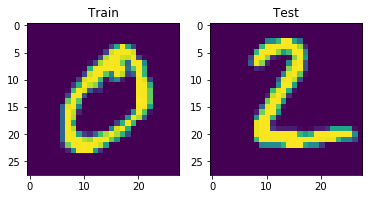

In [3]:
# Train Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# Test Dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

print(f"# train batches: {len(train_loader)}, # test batches: {len(test_loader)}")

print(f"train image: {train_loader.dataset[0][0].size()}")
print(f"test image: {test_loader.dataset[0][0].size()}")

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(train_loader.dataset[1][0].reshape(28,28))
a.set_title("Train")

a = fig.add_subplot(1,2,2)
plt.imshow(test_loader.dataset[1][0].reshape(28,28))
a.set_title("Test")

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        p_value = self.model(img_flat)

        return p_value

# Training

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Generator & Discriminator
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

if CUDA:
    adversarial_loss.cuda(CUDA)
    generator.cuda(CUDA)
    discriminator.cuda(CUDA)
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = 0,0
    delta = time.time()
    
    for batch_idx, (imgs, _label) in enumerate(train_loader):
        if CUDA:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0).cuda(CUDA),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0).cuda(CUDA),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor)).cuda(CUDA)
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))).cuda(CUDA))
        else:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor))
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))))
        
        
        # Generator Training
        optimizer_G.zero_grad()
            
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        
        # Discriminator Training
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_g_loss += g_loss.float()
        epoch_d_loss += d_loss.float()
        
        batches_done = epoch * len(train_loader) + batch_idx
        if batches_done % 400 == 0:
            save_image(gen_imgs.data[:49], 'images/%d.png' % batches_done, nrow=7, normalize=True)
        
    delta = time.time() - delta
    print(f"{delta:.2f} secs [Epoch {epoch}/{EPOCHS}] [D loss: {epoch_d_loss}] [G loss: {epoch_g_loss}]")
        